In [1]:
import calendar

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

import train
import quantiles
import adjust

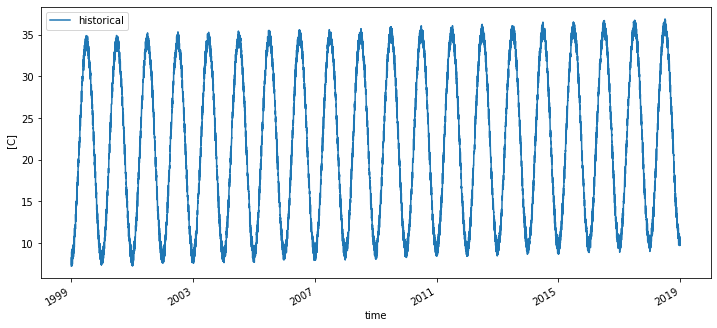

In [2]:
# Create toy data to explore bias adjustment, here fake temperature timeseries
hist_time = pd.date_range("2000-01-01", "2019-12-31", freq="D")
hist_time = hist_time[(hist_time.month != 2) | (hist_time.day != 29)]
da_hist = xr.DataArray(
    (
        -13 * np.cos(2 * np.pi * np.tile(np.arange(1, 366), 20) / 365)
        + 2 * np.random.random_sample((hist_time.size,))
        + 20
        + 0.1 * np.arange(0, hist_time.size) / 365
    ),  # "warming" of 1C per decade,
    dims=("time",),
    coords={"time": hist_time},
    attrs={"units": "C"},
)
ds_hist = da_hist.to_dataset(name='tasmax')

fig = plt.figure(figsize=[12, 5])
da_hist.plot(label="historical")
plt.legend()
plt.show()

In [3]:
#hist_time = xr.cftime_range("2000-01-01", "2019-12-31", freq="D", calendar="noleap")
#da_hist = xr.DataArray(
#    (
#        -13 * np.cos(2 * np.pi * hist_time.dayofyear / 365)
#        + 2 * np.random.random_sample((hist_time.size,))
#        + 20
#        + 0.1 * (hist_time - hist_time[0]).days / 365
#    ),  # "warming" of 1C per decade,
#    dims=("time",),
#    coords={"time": hist_time},
#    attrs={"units": "C"},
#)
#ds_hist = da_hist.to_dataset(name='tasmax')
#
#fig = plt.figure(figsize=[12, 5])
#da_hist.plot(label="historical")
#plt.legend()
#plt.show()

In [4]:
monthly_quantiles = ds_hist['tasmax'].groupby('time.month').quantile([0.25, 0.5, 0.75], dim='time', keep_attrs=True)

In [5]:
da_hist_by_month = ds_hist['tasmax'].groupby('time.month')
below_q50 = da_hist_by_month < monthly_quantiles.sel(quantile=0.5)

In [6]:
# ds_ref: add 1.0 to values below the 50th percentile and 6.0 to values above 50th percentile
ds_ref = ds_hist.copy()
ds_ref['tasmax'] = da_hist_by_month.where(below_q50)
ds_ref['tasmax'] = ds_ref['tasmax'].fillna(ds_hist['tasmax'] + (ds_ref['month'] * 10))
del ds_ref['month']
with xr.set_options(keep_attrs=True):
    ds_ref['tasmax'] = ds_ref['tasmax'] + 1

In [17]:
ref_time = pd.date_range("2040-01-01", "2059-12-31", freq="D")
ref_time = ref_time[(ref_time.month != 2) | (ref_time.day != 29)]
ds_ref['time'] = ref_time

In [18]:
ds_target = ds_hist.copy()

In [19]:
ds_adjust = train.train(ds_hist, ds_ref, 'tasmax', 'tasmax', 'additive')

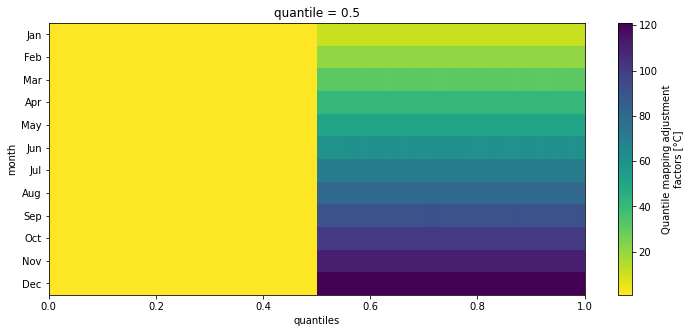

In [20]:
fig = plt.figure(figsize=[12, 5])
ax1 = fig.add_subplot(111)

ds_adjust['af'].transpose('month', 'quantiles').plot(ax=ax1, cmap='viridis_r', extend='neither')
yticks = np.arange(1, 13)
ytick_labels = [calendar.month_abbr[i] for i in yticks]
ax1.set_yticks(yticks, ytick_labels)
ax1.invert_yaxis()

plt.show()

In [21]:
ds_target_q = quantiles.quantiles(ds_target, 'tasmax', 100)

In [22]:
ds_qq = adjust.adjust(
    ds_target,
    'tasmax',
    ds_adjust,
    da_q=ds_target_q['tasmax'],
    reverse_ssr=False,
    ref_time=True,
    interp='nearest'
)

In [23]:
qq_q = quantiles.quantiles(ds_qq, 'tasmax', 100)

In [24]:
qq_q

<xarray.Dataset>
Dimensions:    (quantiles: 100, month: 12)
Coordinates:
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    tasmax     (quantiles, month) float64 8.29 10.52 15.22 ... 124.1 127.6 133.1

In [25]:
def compare_quantiles(month):
    """Quantile comparison"""

    selection = {'month': month}

    obs_data = ds_adjust['hist_q'].isel(selection).values
    qq_data = qq_q['tasmax'].isel(selection).values
    hist_data = ds_adjust['hist_q'].isel(selection).values
    future_data = ds_adjust['ref_q'].isel(selection).values
    quantiles = ds_adjust['quantiles'].data * 100

    fig = plt.figure(figsize=[15, 5])
    ax1 = fig.add_subplot(122)
    ax2 = fig.add_subplot(121)

    ax1.bar(quantiles, obs_data, alpha=0.5, label='observations')
    ax1.bar(quantiles, qq_data, alpha=0.5, label='qq-scaled data')
    ax2.bar(quantiles, hist_data, alpha=0.5, label='historical')
    ax2.bar(quantiles, future_data, alpha=0.5, label='ssp370')

    ax1.set_xlim(0, 100)
    #ax1.set_ylim(0, 120)
    ax1.grid()
    ax1.legend()
    ax1.set_xlabel('quantile')

    ax2.set_xlim(0, 100)
    #ax2.set_ylim(0, 120)
    ax2.grid()
    ax2.legend()
    ax2.set_ylabel('tasmax (C)')
    ax2.set_xlabel('quantile')

    title = calendar.month_name[month + 1]
    plt.suptitle(title)

    plt.show()
    
    print('QQ-data')
    print(qq_data - obs_data)
    
    print('GCM data')
    print(future_data - hist_data)

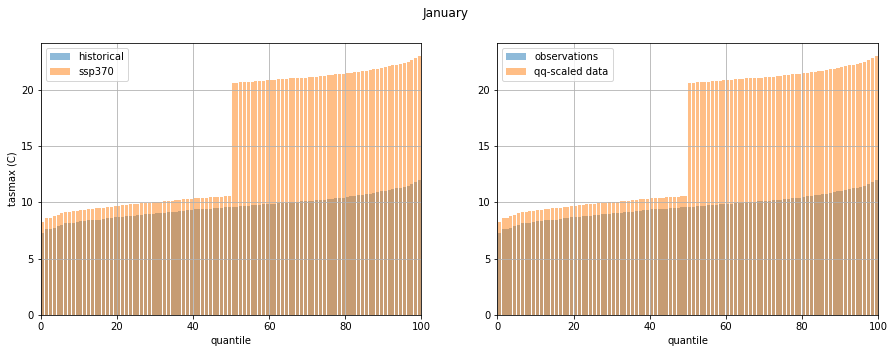

QQ-data
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 11. 11. 11. 11.
 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.]
GCM data
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 11. 11. 11. 11.
 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.]


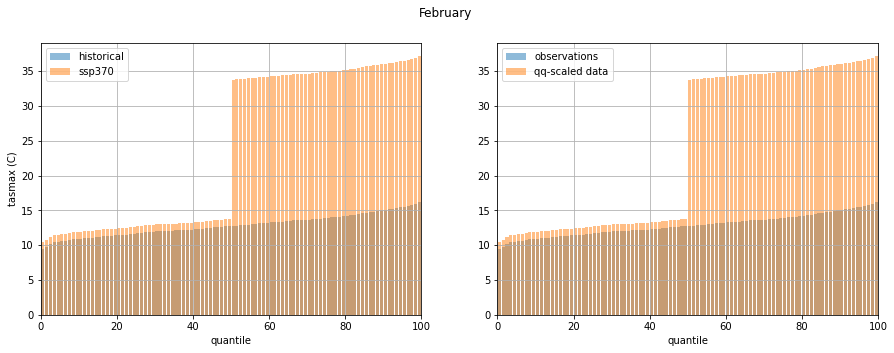

QQ-data
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 21. 21. 21. 21.
 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21.
 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21.
 21. 21. 21. 21. 21. 21. 21. 21. 21. 21.]
GCM data
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 21. 21. 21. 21.
 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21.
 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21.
 21. 21. 21. 21. 21. 21. 21. 21. 21. 21.]


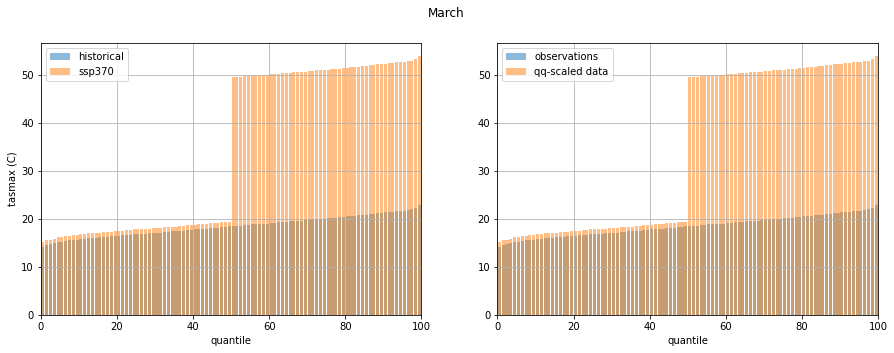

QQ-data
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 31. 31. 31. 31.
 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31.
 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31.
 31. 31. 31. 31. 31. 31. 31. 31. 31. 31.]
GCM data
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 31. 31. 31. 31.
 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31.
 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31.
 31. 31. 31. 31. 31. 31. 31. 31. 31. 31.]


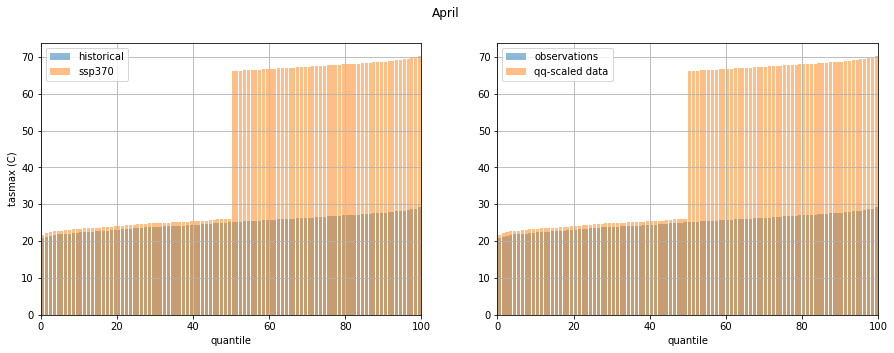

QQ-data
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 41. 41. 41. 41.
 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41.
 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41.
 41. 41. 41. 41. 41. 41. 41. 41. 41. 41.]
GCM data
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 41. 41. 41. 41.
 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41.
 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41. 41.
 41. 41. 41. 41. 41. 41. 41. 41. 41. 41.]


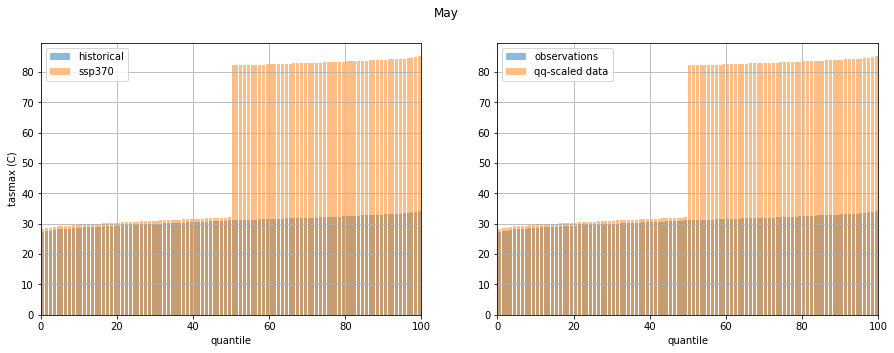

QQ-data
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 51. 51. 51. 51.
 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51.
 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51.
 51. 51. 51. 51. 51. 51. 51. 51. 51. 51.]
GCM data
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 51. 51. 51. 51.
 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51.
 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51.
 51. 51. 51. 51. 51. 51. 51. 51. 51. 51.]


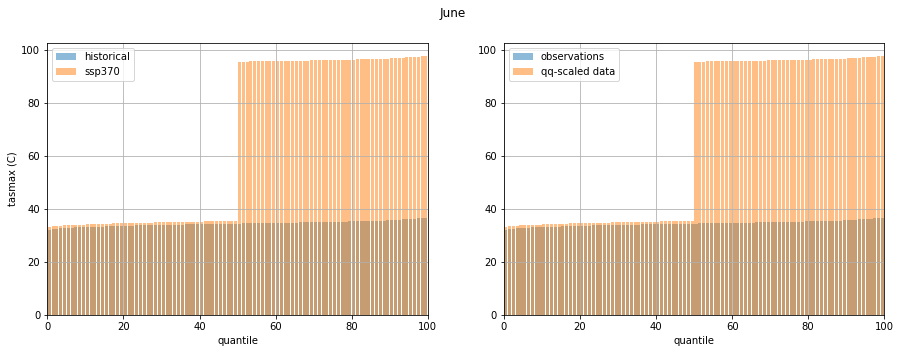

QQ-data
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 61. 61. 61. 61.
 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61.
 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61.
 61. 61. 61. 61. 61. 61. 61. 61. 61. 61.]
GCM data
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 61. 61. 61. 61.
 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61.
 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61.
 61. 61. 61. 61. 61. 61. 61. 61. 61. 61.]


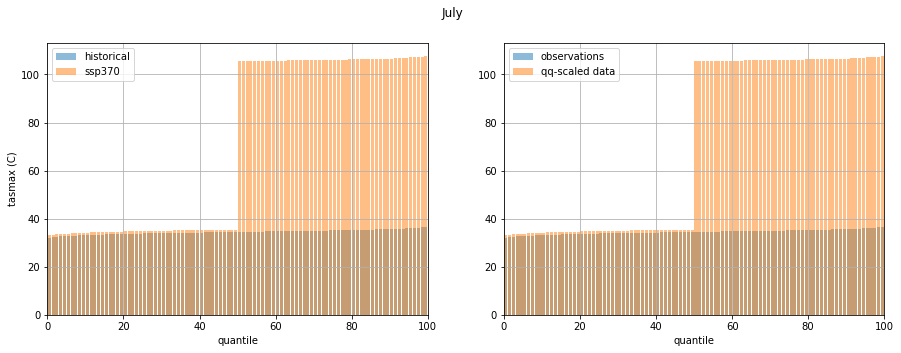

QQ-data
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 71. 71. 71. 71.
 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71.
 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71.
 71. 71. 71. 71. 71. 71. 71. 71. 71. 71.]
GCM data
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 71. 71. 71. 71.
 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71.
 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71.
 71. 71. 71. 71. 71. 71. 71. 71. 71. 71.]


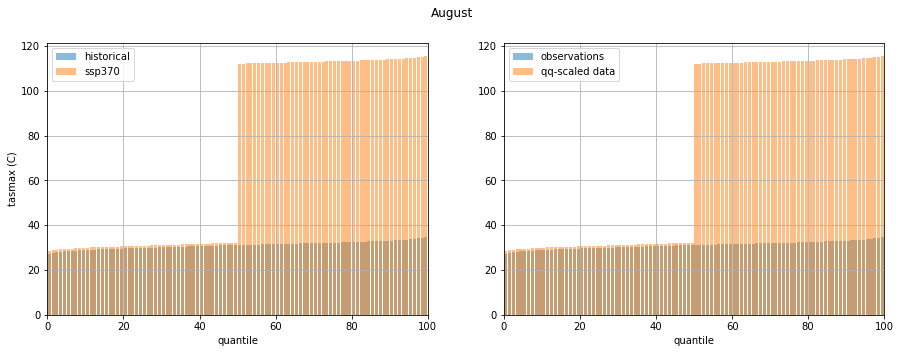

QQ-data
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 81. 81. 81. 81.
 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81.
 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81.
 81. 81. 81. 81. 81. 81. 81. 81. 81. 81.]
GCM data
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 81. 81. 81. 81.
 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81.
 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81.
 81. 81. 81. 81. 81. 81. 81. 81. 81. 81.]


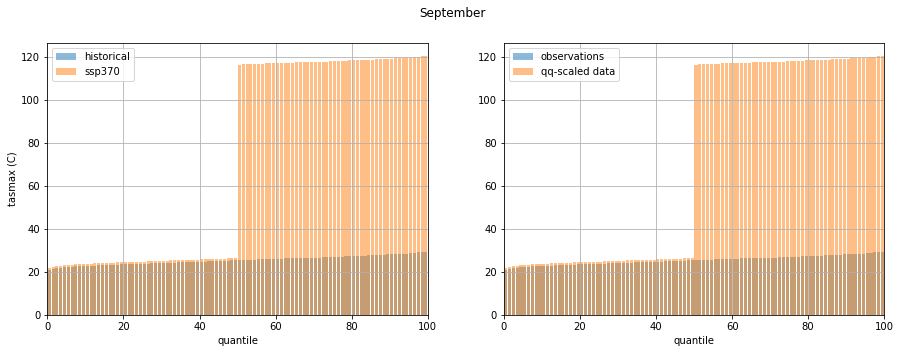

QQ-data
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 91. 91. 91. 91.
 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91.
 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91.
 91. 91. 91. 91. 91. 91. 91. 91. 91. 91.]
GCM data
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 91. 91. 91. 91.
 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91.
 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91.
 91. 91. 91. 91. 91. 91. 91. 91. 91. 91.]


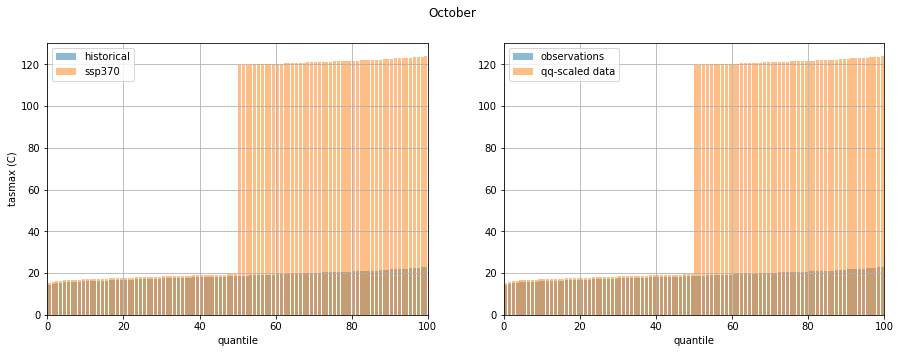

QQ-data
[  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1. 101. 101. 101. 101. 101. 101.
 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101.
 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101.
 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101.
 101. 101.]
GCM data
[  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1. 101. 101. 101. 101. 101. 101.
 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101.
 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101.
 101. 101. 101. 101. 101. 101. 101. 101. 101. 10

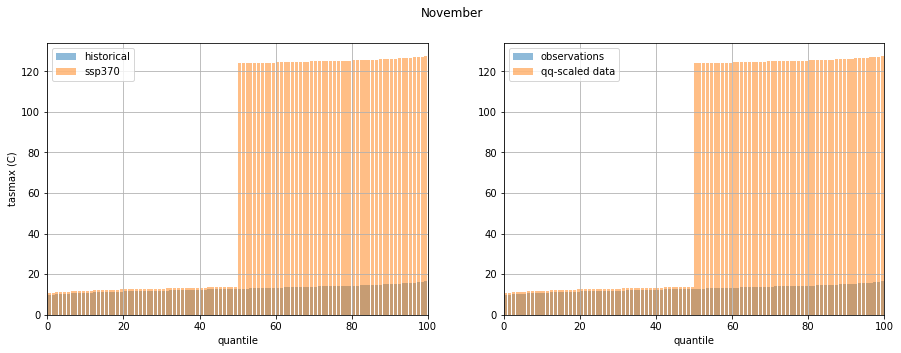

QQ-data
[  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1. 111. 111. 111. 111. 111. 111.
 111. 111. 111. 111. 111. 111. 111. 111. 111. 111. 111. 111. 111. 111.
 111. 111. 111. 111. 111. 111. 111. 111. 111. 111. 111. 111. 111. 111.
 111. 111. 111. 111. 111. 111. 111. 111. 111. 111. 111. 111. 111. 111.
 111. 111.]
GCM data
[  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1. 111. 111. 111. 111. 111. 111.
 111. 111. 111. 111. 111. 111. 111. 111. 111. 111. 111. 111. 111. 111.
 111. 111. 111. 111. 111. 111. 111. 111. 111. 111. 111. 111. 111. 111.
 111. 111. 111. 111. 111. 111. 111. 111. 111. 11

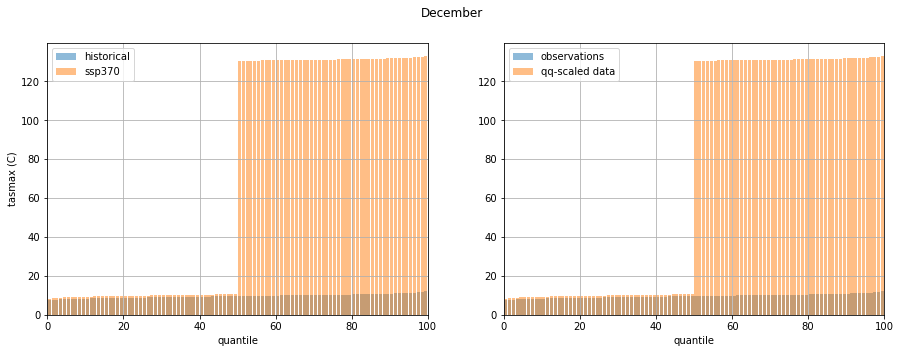

QQ-data
[  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1. 121. 121. 121. 121. 121. 121.
 121. 121. 121. 121. 121. 121. 121. 121. 121. 121. 121. 121. 121. 121.
 121. 121. 121. 121. 121. 121. 121. 121. 121. 121. 121. 121. 121. 121.
 121. 121. 121. 121. 121. 121. 121. 121. 121. 121. 121. 121. 121. 121.
 121. 121.]
GCM data
[  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1. 121. 121. 121. 121. 121. 121.
 121. 121. 121. 121. 121. 121. 121. 121. 121. 121. 121. 121. 121. 121.
 121. 121. 121. 121. 121. 121. 121. 121. 121. 121. 121. 121. 121. 121.
 121. 121. 121. 121. 121. 121. 121. 121. 121. 12

In [26]:
for month in range(12):
    compare_quantiles(month)